# Batch Normalization

One way to make deep networks easier to train is to use more sophisticated optimization procedures such as SGD+momentum, RMSProp, or Adam. Another strategy is to change the architecture of the network to make it easier to train. One idea along these lines is batch normalization which was recently proposed by [1].

The idea is relatively straightforward. **Machine learning methods tend to work better when their input data consists of uncorrelated features with zero mean and unit variance**. When training a neural network, we can preprocess the data before feeding it to the network to explicitly decorrelate its features; this will ensure that the first layer of the network sees data that follows a nice distribution. However even if we preprocess the input data, the activations at deeper layers of the network will likely no longer be decorrelated and will no longer have zero mean or unit variance since they are output from earlier layers in the network. Even worse, during the training process the distribution of features at each layer of the network will shift as the weights of each layer are updated.

The authors of [1] hypothesize that the shifting distribution of features inside deep neural networks may make training deep networks more difficult. To overcome this problem, [1] proposes to insert batch normalization layers into the network. At training time, a batch normalization layer uses a minibatch of data to estimate the mean and standard deviation of each feature. These estimated means and standard deviations are then used to center and normalize the features of the minibatch. **A running average of these means and standard deviations is kept during training, and at test time these running averages are used to center and normalize features**.

It is possible that this normalization strategy could reduce the representational power of the network, since it may sometimes be optimal for certain layers to have features that are not zero-mean or unit variance. To this end, the batch normalization layer includes learnable shift and scale parameters for each feature dimension.

[1] Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift", ICML 2015.

## 1. Basic settings

In [1]:
import time
import numpy as np
from CS231n.classifiers.fc_net import *
from CS231n.data_utils import get_CIFAR10_data
from CS231n.solver import Solver
from CS231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# Optional setting
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## 2. Data loading and Preprocessing

In [5]:
# Load the CIFAR10 data.
DIR_data = 'D:/CS231N_CNN/DataSet/cifar-10-batches-py/'

# the mean image has been sub-tracted
data = get_CIFAR10_data(DIR_data, num_training=49000, num_validation=1000)
# data is a dictionary:
# data = {
#        'X_train': X_train, 'y_train': y_train,
#        'X_val': X_val, 'y_val': y_val,
#        'X_test': X_test, 'y_test': y_test,
#    }

for k, v in data.items():
    print("The shape of %s is " %k,v.shape)

The shape of X_train is  (49000, 3, 32, 32)
The shape of y_train is  (49000,)
The shape of X_val is  (1000, 3, 32, 32)
The shape of y_val is  (1000,)
The shape of X_test is  (1000, 3, 32, 32)
The shape of y_test is  (1000,)


## 3. Batch normalization: Forward

![](BN.PNG)

<font color=#FF0000 >**Code Instruction**</font>

Here, we show the computation one step by one:

(1) Training stage:
```python
# - gamma: Scale parameter of shape (D, )
# - beta: Shift parameter of shape (D,)
# - momentum: Constant for running mean & variance
# Step 1 - shape of mu (D, )
mu = 1 / float(N) * np.sum(x, axis=0)       # this is the mean image of the examples, x:[N,D]

# Step 2 - shape of var (N, D)
xmu = x - mu

# Step 3 - shape of carre (N, D)
carre = xmu**2

# Step 4 - shape of var (D, )
var = 1 / float(N) * np.sum(carre, axis=0)  # this is the variance image of the examples

# Step 5 - shape sqrtvar (D, )
sqrtvar = np.sqrt(var + eps)

# Step 6 - shape invvar (D, )
invvar = 1. / sqrtvar

# Step 7 - shape va2 (N, D)
va2 = xmu * invvar

# Step 8 - shape va3 (N, D)
va3 = gamma * va2           # gamma is broadcasted to (N, D)

# Step 9 - shape out (N, D)
out = va3 + beta            # In this step, beta is broadcast to (N, D)

running_mean = momentum * running_mean + (1.0-momentum)*mu
running_var  = momentum * running_var + (1.0-momentum)*var
```

In [6]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization

# Simulate the forward pass for a two-layer network
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print('  means: ', a.mean(axis=0))
print('  stds: ', a.std(axis=0))

# Means should be close to zero and stds close to one
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

# Now means should be close to beta and stds close to gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print('After batch normalization (nontrivial gamma, beta)')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

Before batch normalization:
  means:  [-20.39411221  -7.23327685 -18.04257768]
  stds:  [ 37.30559826  31.06424657  33.05078556]
After batch normalization (gamma=1, beta=0)
  means:  [ -1.79301018e-16  -1.59317004e-16  -6.66133815e-17]
  stds:  [ 1.          0.99999999  1.        ]
After batch normalization (nontrivial gamma, beta)
  means:  [ 11.  12.  13.]
  stds:  [ 1.          1.99999999  2.99999999]


(2) test stage

```python
mu = running_mean
var = running_var
xhat = (x-mu) / np.sqrt(var + eps)
out = gamma*xhat + beta
```

In [7]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)
for t in range(400):
    X = np.random.randn(N, D1)
    a = np.maximum(0, X.dot(W1)).dot(W2)
    batchnorm_forward(a, gamma, beta, bn_param)

bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

After batch normalization (test-time):
  means:  [ 0.00617944  0.17792457 -0.03830386]
  stds:  [ 1.03003285  1.00357321  0.94607639]


## 4. Batch normalization: Backward

Write out a computation graph for batch normalizaiton on paper and propagate gradients backward through intermediate nodes.

![](BN_graph_naive.png)


<font color=#FF0000 >**Code Instruction**</font>
```python
N, D = dout.shape

# Backprop Step 9
dva3 = dout                   # the shape of dva3 is (N, D)
dbeta = np.sum(dout, axis=0)  # the shape of dbeta is (D, )

# Backprop Step 8
dva2 = gamma * dva3                       # the shape of dva2 is (N, D)
dgamma = np.sum(va2 * dva3, axis=0)       # the shape of dva2 is (D, )

# Backprop Step 7
dxmu = invvar * dva2                      # the shape of dxmu is (N, D)
dinvvar = np.sum(xmu*dva2, axis=0)        # the shape of dinvvar is () 

# Backprop Step 6
dsqrtvar = -1. / (sqrtvar**2) * dinvvar   

# Backprop Step 5
dvar = 0.5 *(var+eps)**(-0.5)*dsqrtvar

# Backprop Step 4
dcarre = 1 / float(N) * np.ones((carre.shape))*dvar

# Backprop Step 3
dxmu += 2 * xmu * dcarre

# Backprop Step 2
dx = dxmu
dmu = -np.sum(dxmu, axis=0)

# Backprop Step 1
dx += 1 / float(N) * np.ones((dxmu.shape))*dmu
```

In [8]:
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.08331199108e-09
dgamma error:  5.64268288026e-12
dbeta error:  6.72302675762e-12


## 5. Batch Normalization: alternative backward
In class we talked about two different implementations for the sigmoid backward pass. One strategy is to write out a computation graph composed of simple operations and backprop through all intermediate values. Another strategy is to work out the derivatives on paper. For the sigmoid function, it turns out that you can derive a very simple formula for the backward pass by simplifying gradients on paper.

Surprisingly, it turns out that you can also derive a simple expression for the batch normalization backward pass if you work out derivatives on paper and simplify. After doing so, implement the simplified batch normalization backward pass in the function batchnorm_backward_alt and compare the two implementations by running the following. Your two implementations should compute nearly identical results, but the alternative implementation should be a bit faster.

NOTE: You can still complete the rest of the assignment if you don't figure this part out, so don't worry too much if you can't get it.

### Draft for the solution
So this, time we want to find $\frac{dL}{d\gamma}$, $\frac{dL}{d\beta}$ and $\frac{dL}{dx}$ with
$$ y = \gamma \hat{x}+\beta$$ where
$$\hat{x}=\frac{x-\mu}{\sqrt{\sigma^2+\epsilon}} = (x-\mu)(\sigma^2+\epsilon)^{-1/2}$$

Therefore, we note for the following that

$$\begin{align}
y_{kl} &= \gamma_l \hat{x_{kl}}+\beta_l\\
\hat{x_{kl}}&=(x_{kl}-\mu_l)(\sigma_l^2+\epsilon)^{-1/2}
\end{align}
$$
where
$$ \begin{align}
\mu_l &= \frac{1}{N}\sum_p x_{pl}\\
\sigma_l^2 &= \frac{1}{N}\sum_p \left(x_{pl}-\mu_l\right)^2
\end{align}
$$
Let's begin by the easy one !

\begin{eqnarray}
\frac{dL}{d\gamma_j} &=& \sum_{kl}\frac{dL}{dy_{kl}}\frac{dy_{kl}}{d\gamma_j}\\
&=& \sum_{kl}\frac{dL}{dy_{kl}}\hat{x_{kl}}\delta_{lj}\\
&=& \sum_{k}\frac{dL}{dy_{kj}}\hat{x_{kj}}
\end{eqnarray}

for $\beta$ we have
\begin{eqnarray}
\frac{dL}{d\beta_j} &=& \sum_{kl}\frac{dL}{dy_{kl}}\frac{dy_{kl}}{d\beta_j}\\
&=& \sum_{kl}\frac{dL}{dy_{kl}}\delta_{lj}\\
&=& \sum_{k}\frac{dL}{dy_{kj}}
\end{eqnarray}

Ok. Let's start the serious one.
\begin{eqnarray}
\frac{dL}{dx_{ij}} &=& \sum_{kl}\frac{dL}{dy_{kl}}\frac{dy_{kl}}{dx_{ij}}\\
&=& \sum_{kl}\frac{dL}{dy_{kl}}\frac{dy_{kl}}{d\hat{x}_{kl}}\frac{d\hat{x}_{kl}}{dx_{ij}}
\end{eqnarray}
where $$\hat{x_{kl}}=(x_{kl}-\mu_l)(\sigma_l^2+\epsilon)^{-1/2}$$.
First, we have:
$$ \frac{dy_{kl}}{d\hat{x}_{kl}} = \gamma_l$$
and
\begin{eqnarray}
\frac{d\hat{x}_{kl}}{dx_{ij}} = (\delta_{ik}\delta_{jl}-\frac{1}{N}\delta_{jl})(\sigma_l^2+\epsilon)^{-1/2}-\frac{1}{2}(x_{kl}-\mu_l)\frac{d\sigma_l^2}{dx_{ij}}(\sigma_l^2+\epsilon)^{-3/2}
\end{eqnarray}
where 
$$\sigma_l^2 = \frac{1}{N}\sum_p \left(x_{pl}-\mu_l\right)^2$$
and then,
\begin{eqnarray}
\frac{d\sigma_l^2}{dx_{ij}} &=& \frac{1}{N}\sum_p2\left(\delta_{ip}\delta_{jl}-\frac{1}{N}\delta_{jl}\right)\left(x_{pl}-\mu_l\right)\\
&=&\frac{2}{N}(x_{il}-\mu_l)\delta_{jl}-\frac{2}{N^2}\sum_p\delta_{jl}\left(x_{pl}-\mu_l\right)\\
&=& \frac{2}{N}(x_{il}-\mu_l)\delta_{jl}
\end{eqnarray}
This is because $\sum_p\delta_{jl}\left(x_{pl}-\mu_l\right)=0$.

Putting everything together we thus have
\begin{eqnarray}
\frac{d\hat{x}_{kl}}{dx_{ij}} = (\delta_{ik}\delta_{jl}-\frac{1}{N}\delta_{jl})(\sigma_l^2+\epsilon)^{-1/2}-\frac{1}{N}(x_{kl}-\mu_l)(x_{il}-\mu_l)\delta_{jl}(\sigma_l^2+\epsilon)^{-3/2}
\end{eqnarray}

and therefore

\begin{eqnarray}
\frac{dL}{dx_{ij}} &=& \sum_{kl}\frac{dL}{dy_{kl}}\frac{dy_{kl}}{d\hat{x}_{kl}}\frac{d\hat{x}_{kl}}{dx_{ij}}\\
&=& \sum_{kl}\frac{dL}{dy_{kl}}\gamma_l\left((\delta_{ik}\delta_{jl}-\frac{1}{N}\delta_{jl})(\sigma_l^2+\epsilon)^{-1/2}-\frac{1}{N}(x_{kl}-\mu_l)(x_{il}-\mu_l)\delta_{jl}(\sigma_l^2+\epsilon)^{-3/2}\right)\\
&=&\sum_{kl}\frac{dL}{dy_{kl}}\gamma_l\left((\delta_{ik}\delta_{jl}-\frac{1}{N}\delta_{jl})(\sigma_l^2+\epsilon)^{-1/2}\right)-\sum_{kl}\frac{dL}{dy_{kl}}\gamma_l\left(\frac{1}{N}(x_{kl}-\mu_l)(x_{il}-\mu_l)\delta_{jl}(\sigma_l^2+\epsilon)^{-3/2}\right)\\
&=&\frac{dL}{dy_{ij}}\gamma_j(\sigma_j^2+\epsilon)^{-1/2}-\frac{1}{N}\sum_{k}\frac{dL}{dy_{kj}}\gamma_j(\sigma_j^2+\epsilon)^{-1/2}-\frac{1}{N}\sum_{k}\frac{dL}{dy_{kj}}\gamma_j\left((x_{kj}-\mu_j)(x_{ij}-\mu_j)(\sigma_j^2+\epsilon)^{-3/2}\right)\\
&=&\frac{1}{N}\gamma_j(\sigma_j^2+\epsilon)^{-1/2}\left(N\frac{dL}{dy_{ij}}-\sum_k\frac{dL}{dy_{kj}}-(x_{ij}-\mu_j)(\sigma_j^2+\epsilon)^{-1}\sum_k\frac{dL}{dy_{kj}}(x_{kj}-\mu_j)\right)
\end{eqnarray}

<font color=#FF0000 >**Code Instruction**</font>
```python
N, D = x.shape

dbeta = np.sum(dout, axis=0)
dgamma = np.sum(xmu * invvar * dout, axis=0)
dx = (1.0/N) * gamma * (var+eps)**(-1.0/2.0) *(N*dout - np.sum(dout, axis=0)
                     - (x-mu) * (var+eps)**(-1.0) * np.sum(dout*(x-mu), axis=0))
```

In [9]:
N, D = 100, 500
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
out, cache = batchnorm_forward(x, gamma, beta, bn_param)

t1 = time.time()
dx1, dgamma1, dbeta1 = batchnorm_backward(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = batchnorm_backward_alt(dout, cache)
t3 = time.time()

print('dx difference: ', rel_error(dx1, dx2))
print('dgamma difference: ', rel_error(dgamma1, dgamma2))
print('dbeta difference: ', rel_error(dbeta1, dbeta2))
#print('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))

dx difference:  8.93939315661e-13
dgamma difference:  0.0
dbeta difference:  0.0


## 6.  Fully Connected Nets with Batch Normalization

We insert a batch normalization layer before each ReLU nonlinearity. **The outputs from the last layer of the network should not be normalized**. In the model construction, we perform
```python
if self.use_batchnorm:
    print('We use batchnorm here')
    self.bn_params = {'bn_param' + str(i+1): {'mode': 'train',
                                              'running_mean': np.zeros(dims[i+1]),
                                              'running_var': np.zeros(dims[i+1])}
                       for i in range(len(dims)-2)}
    # Note the length of bn_params is len(dims) - 2

    gammas = {'gamma' + str(i+1): np.ones(dims[i + 1]) for i in range(len(dims)-2)}
    betas = {'beta' + str(i+1): np.zeros(dims[i + 1]) for i in range(len(dims)-2)}
    self.params.update(betas)
    self.params.update(gammas)
```

### 6.1 Gradient check

First, we compare the gradient of the model parameters calculated with analytical expressions with numerical calculation.

In [10]:
N, D, H1, H2, C = 2, 10, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], 
                              input_dim=D, 
                              num_classes=C,
                              reg=reg, 
                              weight_scale=5e-2, 
                              dtype=np.float64,
                              use_batchnorm=True)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    if reg == 0: 
        print

Running check with reg =  0
We use batchnorm here
Initial loss:  2.39569585844
Running check with reg =  3.14
We use batchnorm here
Initial loss:  6.36904630753
W1 relative error: 7.93e-05
W2 relative error: 2.66e-06
W3 relative error: 9.77e-08
b1 relative error: 5.75e-09
b2 relative error: 3.19e-08
b3 relative error: 2.47e-10
beta1 relative error: 3.52e-09
beta2 relative error: 1.03e-08
gamma1 relative error: 2.35e-09
gamma2 relative error: 7.76e-09


### 6.2. Batch normalization and initialization

We will now run a small experiment to study the **interaction of batch normalization and weight initialization**.

The first cell will train 8-layer networks both with and without batch normalization using different scales for weight initialization. 

The second layer will plot training accuracy, validation set accuracy, and training loss as a function of the weight initialization scale.

In [11]:
# Try training a very deep net with batchnorm
hidden_dims = [50, 50, 50, 50, 50, 50, 50]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers = {}
solvers = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
    
    print('Running weight scale %d / %d'%(i+1,len(weight_scales)))
    
    # a deep net with BN
    bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
    bn_solver = Solver(bn_model, small_data,
                       num_epochs=10, batch_size=50,
                       update_rule='Adam',
                       optim_config={
                           'learning_rate':1e-3
                       },
                       verbose=False, print_every=200)
    bn_solver.train()
    bn_solvers[weight_scale] = bn_solver
    
    # a deep net without BN
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale)
    solver = Solver(model, small_data,
                    num_epochs=10, batch_size=50,
                    update_rule='Adam',
                    optim_config={
                        'learning_rate':1e-3
                    },
                    verbose=False, print_every=200)
    solver.train()
    solvers[weight_scale] = solver

Running weight scale 1 / 20
We use batchnorm here
Running weight scale 2 / 20
We use batchnorm here
Running weight scale 3 / 20
We use batchnorm here
Running weight scale 4 / 20
We use batchnorm here
Running weight scale 5 / 20
We use batchnorm here
Running weight scale 6 / 20
We use batchnorm here
Running weight scale 7 / 20
We use batchnorm here
Running weight scale 8 / 20
We use batchnorm here
Running weight scale 9 / 20
We use batchnorm here
Running weight scale 10 / 20
We use batchnorm here
Running weight scale 11 / 20
We use batchnorm here
Running weight scale 12 / 20
We use batchnorm here
Running weight scale 13 / 20
We use batchnorm here
Running weight scale 14 / 20
We use batchnorm here
Running weight scale 15 / 20
We use batchnorm here
Running weight scale 16 / 20
We use batchnorm here


D:\CS231N_CNN\notebook\Assignment2\CS231n\layers.py:703: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N


Running weight scale 17 / 20
We use batchnorm here
Running weight scale 18 / 20
We use batchnorm here
Running weight scale 19 / 20
We use batchnorm here
Running weight scale 20 / 20
We use batchnorm here


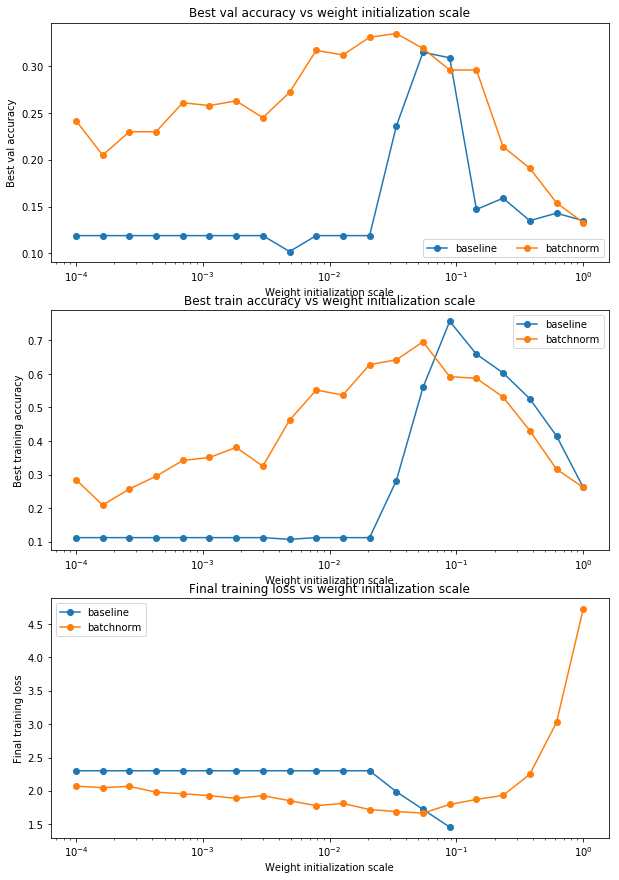

In [12]:
# Plot results of weight scale experiment
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
    best_train_accs.append(max(solvers[ws].train_acc_history))
    bn_best_train_accs.append(max(bn_solvers[ws].train_acc_history))

    best_val_accs.append(max(solvers[ws].val_acc_history))
    bn_best_val_accs.append(max(bn_solvers[ws].val_acc_history))

    final_train_loss.append(np.mean(solvers[ws].loss_history))
    bn_final_train_loss.append(np.mean(bn_solvers[ws].loss_history))

plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()

plt.gcf().set_size_inches(10, 15)
plt.show()

### 6.3. Batchnorm for deep networks
Run the following to train a six-layer network on a subset of 1000 training examples both with and without batch normalization.

In [13]:
hidden_dims = [100, 100, 100, 100]
num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}
weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, reg=0.1, use_batchnorm=True)
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, reg=0.1, use_batchnorm=False)

bn_solver = Solver(bn_model, small_data,
                num_epochs=30, batch_size=50,
                update_rule='Adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
bn_solver.train()

solver = Solver(model, small_data,
                num_epochs=30, batch_size=50,
                update_rule='Adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
solver.train()

We use batchnorm here
(Iteration "1" / "600") loss: "9.110182"
(Epoch "0" / "30") train acc: "0.143000"; val_acc: "0.116000"
(Epoch "1" / "30") train acc: "0.374000"; val_acc: "0.297000"
(Epoch "2" / "30") train acc: "0.417000"; val_acc: "0.306000"
(Epoch "3" / "30") train acc: "0.476000"; val_acc: "0.312000"
(Epoch "4" / "30") train acc: "0.500000"; val_acc: "0.332000"
(Epoch "5" / "30") train acc: "0.534000"; val_acc: "0.323000"
(Epoch "6" / "30") train acc: "0.569000"; val_acc: "0.336000"
(Epoch "7" / "30") train acc: "0.577000"; val_acc: "0.349000"
(Epoch "8" / "30") train acc: "0.581000"; val_acc: "0.311000"
(Epoch "9" / "30") train acc: "0.658000"; val_acc: "0.334000"
(Epoch "10" / "30") train acc: "0.700000"; val_acc: "0.354000"
(Iteration "201" / "600") loss: "1.749399"
(Epoch "11" / "30") train acc: "0.654000"; val_acc: "0.298000"
(Epoch "12" / "30") train acc: "0.713000"; val_acc: "0.328000"
(Epoch "13" / "30") train acc: "0.750000"; val_acc: "0.330000"
(Epoch "14" / "30") tr

Run the following to visualize the results from two networks trained above. You should find that using batch normalization helps the network to converge much faster.

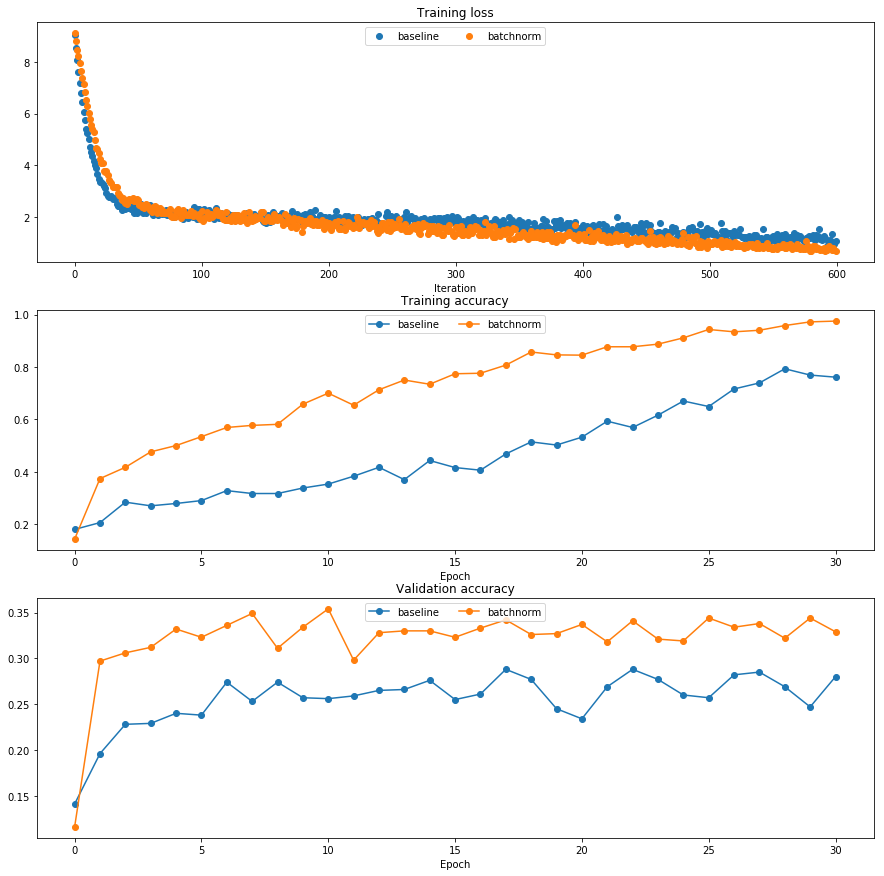

In [14]:
plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(solver.loss_history, 'o', label='baseline')
plt.plot(bn_solver.loss_history, 'o', label='batchnorm')

plt.subplot(3, 1, 2)
plt.plot(solver.train_acc_history, '-o', label='baseline')
plt.plot(bn_solver.train_acc_history, '-o', label='batchnorm')

plt.subplot(3, 1, 3)
plt.plot(solver.val_acc_history, '-o', label='baseline')
plt.plot(bn_solver.val_acc_history, '-o', label='batchnorm')

for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
    
plt.gcf().set_size_inches(15, 15)
plt.show()

## 7. Why Batchnormalization works?

Refer to [深度学习中 Batch Normalization为什么效果好？](https://www.zhihu.com/question/38102762) and [Batch Normalization详解](http://jiangqh.info/Batch-Normalization%E8%AF%A6%E8%A7%A3/).

BN is introduced to overcome the difficulty of training a deep neural network. 

**Internal Covariate Shift**.

  In the statistical machine learning, there is **a classic hypothesis that the data distribution are common in the source domain and target domain**. If the distribution are different, new machine learning issues arise, such as the transfer learning and domain adaptation. **Covariate Shift** is one case of such distribution variance, which means that the conditional distribution in source domain and target domain are common, but the margin distribution are different: 
  >for all $x \in {\bf{X}}$, ${P_s}\left( {Y\left| {X = x} \right.} \right) = {P_t}\left( {Y\left| {X = x} \right.} \right)$, but ${P_s}\left( X \right) \ne {P_t}\left( X \right)$. 

  This could be obvius. For each layer of the neural network, because of their intra-layer operation, the output distribution is clearly different with the corresponding input signal distribution, and the difference will increase with the network depth increases, but the sample label (label) is still the same, which will meet the definition of covariate shift. Because of the analysis of the interlayer signal, that is, the "internal" reason.

In fact, if trying to solve the covariate shift accordance with the traditional solution strictly, we may probably use some type of "importance weight" methods. But here Google just said, "**We propose a new mechanism, which we call Batch Normalization, that takes a step towards reducing internal covariate shift, and in doing so dramatically accelerates the traicning of deep neural nets. It accomplishes this via a normalization step that fixes the means and variances of layer inputs.**"  If covariate shift can be overcome in such a simple way, then research of it is really wasteful. In addition, imagine that the distribution of mean/variance is the same distribution? of course not. Obviously, ICS is just a "wrapping paper" Well, just a high-level demonstration.